Importing required libraries. Using nibabel to load NIfTI files, nilearn for neuroimaging utilities, and matplotlib to visualize the extracted time series.

In [10]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

from nilearn import plotting, image, datasets, masking
from nilearn.input_data import NiftiLabelsMasker

Load the preprocessed fMRI image using nibabel. Functional images are 4D (x, y, z, time). Also confirm its shape.

In [11]:
# Define path to subject's fMRI file
func_file = '/autofs/vast/neuromod/NIFTI/ECTRO1/derivatives/fmriprep/sub-ECTRO102/ses-V1/func/sub-ECTRO102_ses-V1_task-rest_dir-AP_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'

# Load the image
fmri_img = nib.load(func_file)
print(fmri_img.shape)

(97, 115, 97, 488)


Visualize the first volume (time point 0) to check if the image looks like expected fMRI data.

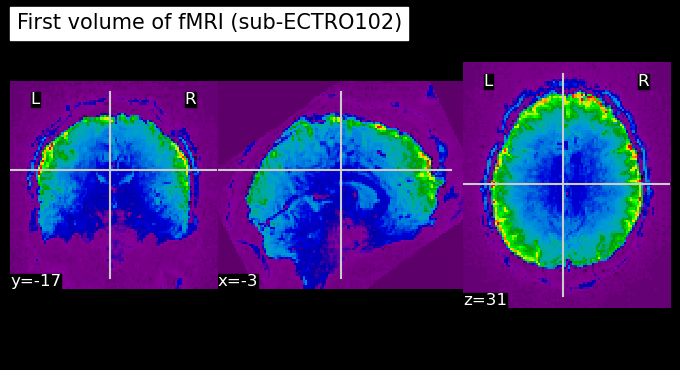

In [13]:
# Show a middle slice of volume 0 (first time point)
plotting.plot_epi(image.index_img(fmri_img, 0), title="First volume of fMRI (sub-ECTRO102)")

Loading the Schaefer 2018 atlas (100 regions) to identify specific brain areas (PCC and/or ACC which are both part of the default mode and salience networks respectively).

In [14]:
# Fetch the Schaefer 2018 100-region, 7-network parcellation (in MNI space)
schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7, resolution_mm=1)
atlas_img = nib.load(schaefer['maps'])
labels = schaefer['labels']

print("Schaefer Atlas loaded with", len(labels), "regions.")

Schaefer Atlas loaded with 100 regions.


Extract the time series. Use NiftiLabelsMasker to extract the mean BOLD signal over time from all brain regions then standardize the signal for visualization.

In [19]:
# Decode all labels (i.e. convert labels from bytes to strings)
decoded_labels = [label.decode("utf-8") for label in labels]

# Pass the full atlas and full label list
masker = NiftiLabelsMasker(labels_img=atlas_img,
                           labels=decoded_labels,
                           standardize=True,
                           verbose=1)

# Run extraction (outputs time series for ALL 100 atlas regions)
all_time_series = masker.fit_transform(fmri_img)

/home/scratch/ipykernel_375743/4258635003.py:5: UserWarning: Mismatch between the number of provided labels (100) and the number of regions in provided label image (101).
  masker = NiftiLabelsMasker(labels_img=atlas_img,


[NiftiLabelsMasker.wrapped] loading data from Nifti1Image('/homes/2/ac2394/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz')
Resampling labels
[NiftiLabelsMasker.transform_single_imgs] Loading data from Nifti1Image('/autofs/vast/neuromod/NIFTI/ECTRO1/derivatives/fmriprep/sub-ECTRO102/ses-V1/func/sub-ECTRO102_ses-V1_task-rest_dir-AP_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals


/autofs/vast/neuromod/2023Temp/ani_chintha/conda_envs/env_mriIntro/lib/python3.11/site-packages/nilearn/maskers/base_masker.py:253: UserWarning: Mismatch between the number of provided labels (100) and the number of regions in provided label image (101).
Note that this may be due to some regions being dropped from the label image after resampling.
  return self.transform_single_imgs(


Identifying PCC/ACC in the atlas. Searching for the appropriate label index using a substring match for "PCC" or "ACC". The Schaefer atlas encodes region names in the label list.

In [20]:
# Now search for PCC and ACC
pcc_indices = [i for i, label in enumerate(decoded_labels) if 'PCC' in label]
acc_indices = [i for i, label in enumerate(decoded_labels) if 'ACC' in label]

# Pick one of them
pcc_idx = pcc_indices[0] if pcc_indices else None
acc_idx = acc_indices[0] if acc_indices else None

# Print matched labels
if pcc_idx is not None: print("PCC label:", decoded_labels[pcc_idx])
if acc_idx is not None: print("ACC label:", decoded_labels[acc_idx])

PCC label: 7Networks_LH_Default_pCunPCC_1


Choose the region of interest and extract just the ROI from the all_time_series

In [25]:
# Now isolate the region you want
ROI = pcc_idx

# Extract just the PCC time series
time_series = all_time_series[:, ROI]
print("Extraction Successful" if time_series.any() else "No Extraction")

Extraction Successful


Plot the Time Series. Visualize the extracted BOLD signal for the PCC (or ACC). The x-axis represents time (each timepoint = 1 TR), and the y-axis is the standardized BOLD response.

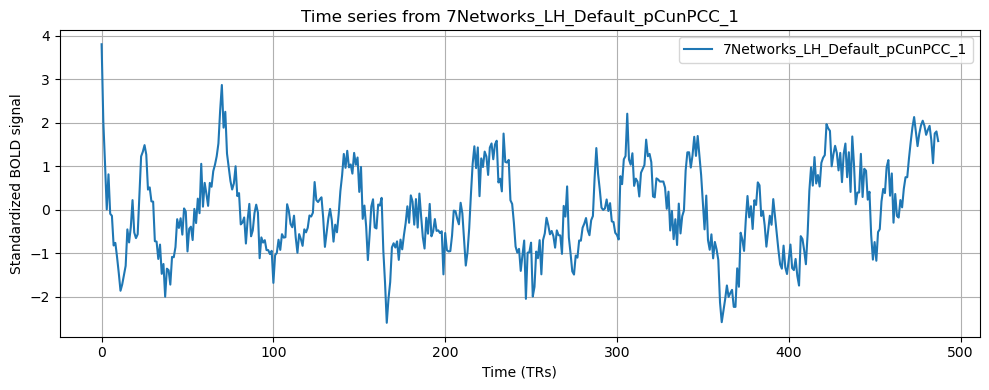

In [31]:
plt.figure(figsize=(10, 4))
plt.plot(time_series, label=decoded_labels[ROI])
plt.xlabel("Time (TRs)")
plt.ylabel("Standardized BOLD signal")
plt.title(f"Time series from {decoded_labels[ROI]}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()